In [62]:
# import library 
import numpy as np
from numpy import asarray
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import Data
## Reading the data. Explicitly mentioned to read the date column in data as date.  Make date column as index

In [2]:
df = pd.read_csv("..\Resources\Prod_Forecast.csv",parse_dates=['Date'], index_col='Date', dayfirst=True)
df.head()

,Well,Well_Type,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,,,
2015-01-10,Well 10,Pre-perf,192.00,51.00,38.00,63.00,235.00,2.00
2015-01-11,Well 10,Pre-perf,308.00,43.00,31.00,67.00,235.00,37.00
2015-01-12,Well 10,Pre-perf,308.00,41.00,31.00,67.00,239.00,59.00
2015-01-13,Well 10,Pre-perf,309.09,40.53,29.90,67.04,238.86,59.69
2015-01-14,Well 10,Pre-perf,308.18,40.46,29.84,67.06,236.16,56.57


In [3]:
Wellnames = df.Well.unique()
Wellnames

array(['Well 10', 'Well 11', 'Well 12', 'Well 13', 'Well 15', 'Well 14',
       'Well 1', 'Well 2', 'Well 3', 'Well 4', 'Well 5', 'Well 6',
       'Well 7', 'Well 8', 'Well 9'], dtype=object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10014 entries, 2015-01-10 to 2018-08-04
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Well                10014 non-null  object 
 1   Well_Type           10014 non-null  object 
 2   WaterRate           10014 non-null  float64
 3   CasingHeadPressure  10014 non-null  float64
 4   TubingHeadPressure  10014 non-null  float64
 5   PumpSpeed           10014 non-null  float64
 6   Torque              10014 non-null  float64
 7   GasRate             10014 non-null  float64
dtypes: float64(6), object(2)
memory usage: 704.1+ KB


In [5]:
df.describe()

,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
count,10014.000000,10014.000000,10014.000000,10014.000000,10014.000000,10014.000000
mean,255.401030,58.345532,57.180661,143.820432,246.935557,446.143849
std,186.126892,35.609559,20.591074,62.513463,115.562883,400.881072
min,0.000000,23.000000,0.040000,0.000000,0.010000,0.000000
25%,118.280000,42.060000,42.500000,100.000000,154.335000,171.482500
50%,221.490000,51.050000,53.850000,135.000000,242.660000,337.430000
75%,366.010000,61.350000,70.477500,188.000000,314.000000,548.610000
max,1184.130000,397.000000,387.000000,343.000000,753.000000,1867.940000


## Check if any null value

In [6]:
df.isnull().sum()

Well                  0
Well_Type             0
WaterRate             0
CasingHeadPressure    0
TubingHeadPressure    0
PumpSpeed             0
Torque                0
GasRate               0
dtype: int64

In [29]:
wellcount = df.Well.value_counts()
wellcount

Well 1     1359
Well 7     1230
Well 15    1220
Well 9     1199
Well 10    1078
Well 8     1052
Well 14     605
Well 12     384
Well 13     372
Well 6      358
Well 2      277
Well 3      277
Well 4      274
Well 5      168
Well 11     161
Name: Well, dtype: int64

## As can be seen from the above the data consist of 15 wells. We are going to use Well 1 to train and test our model and use other Well data for validation.

In [30]:
Well = df[df['Well'] == 'Well 1']
Well

,Well,Well_Type,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,,,
2014-12-22,Well 1,Pre-perf,3.00,51.00,18.00,1.00,1.00,6.00
2014-12-23,Well 1,Pre-perf,90.00,29.00,29.00,88.00,186.00,0.00
2014-12-24,Well 1,Pre-perf,100.00,29.00,30.00,98.00,191.00,0.00
2014-12-25,Well 1,Pre-perf,102.89,29.12,29.68,97.77,167.97,0.00
2014-12-26,Well 1,Pre-perf,104.00,29.00,30.00,98.00,156.00,0.00
...,...,...,...,...,...,...,...,...
2018-12-27,Well 1,Pre-perf,33.48,48.73,48.49,134.00,116.53,134.93
2018-12-28,Well 1,Pre-perf,33.73,50.33,50.38,134.00,116.53,134.75
2018-12-29,Well 1,Pre-perf,33.64,50.33,50.84,134.00,115.80,134.00


## Drop unneccessary columns

In [31]:
Well.drop(['Well', 'Well_Type'], axis = 1, inplace = True)

In [32]:
Well.sort_index(inplace = True)
Well

,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,
2014-12-22,3.00,51.00,18.00,1.00,1.00,6.00
2014-12-23,90.00,29.00,29.00,88.00,186.00,0.00
2014-12-24,100.00,29.00,30.00,98.00,191.00,0.00
2014-12-25,102.89,29.12,29.68,97.77,167.97,0.00
2014-12-26,104.00,29.00,30.00,98.00,156.00,0.00
...,...,...,...,...,...,...
2018-12-27,33.48,48.73,48.49,134.00,116.53,134.93
2018-12-28,33.73,50.33,50.38,134.00,116.53,134.75
2018-12-29,33.64,50.33,50.84,134.00,115.80,134.00


# Problem Statement
## To forecast Gas Rate based on the drilling data

## To be able to forecast current GasRate we can frame the problem as supervised learning problem. This re-framing of time series data allows access to the suite of standard linear and nonlinear machine learning algorithms. This is called `Sliding Window`. In short, we are going to forecast the current Gas Rate (t) based on the previous features/drilling including Gas rate data on the previous day (t-1). 

 

In [33]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		# names += [f'{col} (t-{i})' for col in cols]
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			# names += [f'{col} (t)' for col in cols]
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			# names += [f'{col} (t+{i})' for col in cols]
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [34]:
# # normalize features
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(Well)

In [35]:
# frame as supervised learning
# reframed = series_to_supervised(scaled, 1, 1)

In [36]:
reframed = series_to_supervised(Well, 1, 1)

## We are only interested in forecasting Gas Rate (var6), hence we well removed the other variables for (t)

In [37]:
reframed.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace= True)

In [38]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var6(t)
Date,,,,,,,
2014-12-23,3.00,51.00,18.00,1.00,1.00,6.00,0.00
2014-12-24,90.00,29.00,29.00,88.00,186.00,0.00,0.00
2014-12-25,100.00,29.00,30.00,98.00,191.00,0.00,0.00
2014-12-26,102.89,29.12,29.68,97.77,167.97,0.00,0.00
2014-12-27,104.00,29.00,30.00,98.00,156.00,0.00,0.00
...,...,...,...,...,...,...,...
2018-12-27,33.47,48.15,49.30,134.00,116.53,134.78,134.93
2018-12-28,33.48,48.73,48.49,134.00,116.53,134.93,134.75
2018-12-29,33.73,50.33,50.38,134.00,116.53,134.75,134.00


# Train Test Dataset
## Unlike traditional ML problem, where the sequence is not important in predicting the result, in Timeseries the information of previous result is important. In this model, we will use the last year dataset as test dataset, while data prior to last year as training. 

In [39]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data.iloc[:-n_test, :], data.iloc[-n_test:, :]

In [40]:
train, test = train_test_split(reframed, 365)
train

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var6(t)
Date,,,,,,,
2014-12-23,3.00,51.00,18.00,1.00,1.00,6.00,0.00
2014-12-24,90.00,29.00,29.00,88.00,186.00,0.00,0.00
2014-12-25,100.00,29.00,30.00,98.00,191.00,0.00,0.00
2014-12-26,102.89,29.12,29.68,97.77,167.97,0.00,0.00
2014-12-27,104.00,29.00,30.00,98.00,156.00,0.00,0.00
...,...,...,...,...,...,...,...
2017-12-27,34.54,39.02,39.31,109.00,92.20,164.17,162.56
2017-12-28,33.57,38.87,39.02,109.00,92.93,162.56,161.99
2017-12-29,33.55,39.74,40.03,109.00,92.20,161.99,162.59


In [41]:
test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var6(t)
Date,,,,,,,
2018-01-01,34.10,39.31,39.45,109.0,92.20,162.38,162.01
2018-01-02,34.18,39.45,39.74,109.0,92.20,162.01,161.74
2018-01-03,34.11,38.87,39.16,109.0,91.46,161.74,161.22
2018-01-04,33.93,38.87,39.16,109.0,91.46,161.22,162.16
2018-01-05,34.46,38.87,39.16,109.0,91.46,162.16,161.24
...,...,...,...,...,...,...,...
2018-12-27,33.47,48.15,49.30,134.0,116.53,134.78,134.93
2018-12-28,33.48,48.73,48.49,134.0,116.53,134.93,134.75
2018-12-29,33.73,50.33,50.38,134.0,116.53,134.75,134.00


In [49]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	# split into input and output columns
	trainX, trainy = train.iloc[:, :-1], train.iloc[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000,
			# criterion = 'mae',
			# max_depth = 5,
			bootstrap = True,
			oob_score = True
	)
	model.fit(trainX, trainy)
	# make a one-step prediction
	# print(testX)
	yhat = model.predict(testX)
	filename = 'finalized_model.sav'
	pickle.dump(model, open(filename, 'wb'))
	# print(yhat)
	return yhat[0], model

In [50]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = []
	# # split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	test_index = test.index
	train_df = train
	# step over each time-step in the test set
	for i, ind in enumerate(test_index):
		# split test row into input and output columns
		testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
		testX = testX.to_numpy().reshape(1,-1)
		# fit model on history and make a prediction
		yhat, model = random_forest_forecast(train_df, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		train_df.append(test.loc[ind])

		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	MAE = mean_absolute_error(test.iloc[:, -1], predictions)
	r2 = r2_score(test.iloc[:, -1], predictions)
	return MAE,r2, test.iloc[:, -1], predictions, model

In [74]:
# mae= walk_forward_validation(reframed, 2)
mae,r2, y, yhat, model = walk_forward_validation(reframed, 61)


>expected=143.7, predicted=145.2
>expected=144.2, predicted=143.6
>expected=143.9, predicted=144.8
>expected=143.9, predicted=144.6
>expected=143.8, predicted=144.8
>expected=145.6, predicted=143.6
>expected=146.0, predicted=145.4
>expected=144.9, predicted=146.0
>expected=143.2, predicted=145.4
>expected=139.0, predicted=143.4
>expected=141.0, predicted=138.8
>expected=141.0, predicted=140.2
>expected=141.2, predicted=140.5
>expected=140.7, predicted=140.5
>expected=140.3, predicted=140.2
>expected=140.5, predicted=139.6
>expected=141.2, predicted=140.2
>expected=141.6, predicted=140.6
>expected=139.6, predicted=140.4
>expected=138.7, predicted=138.6
>expected=138.4, predicted=138.2
>expected=137.9, predicted=138.5
>expected=137.9, predicted=138.1
>expected=136.8, predicted=138.1
>expected=136.9, predicted=138.4
>expected=139.8, predicted=139.9
>expected=141.8, predicted=140.2
>expected=141.0, predicted=141.4
>expected=140.8, predicted=141.1
>expected=140.7, predicted=140.9
>expected=

In [75]:
r2

0.3252297807970551

In [76]:
model.oob_score_
mae

1.936470163934574

<AxesSubplot:xlabel='Date'>

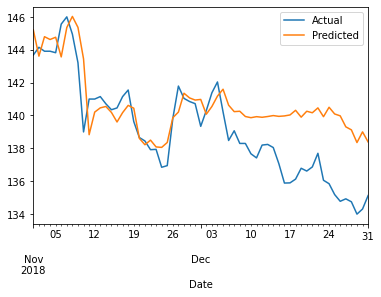

In [77]:
comparison = pd.DataFrame({'Actual': y, 'Predicted': yhat})
comparison.plot(kind='line')

## Test model with other well

In [78]:
Wells = {}
for well in Wellnames:
    Wells[f'{well}'] = df[df['Well'] == f'{well}']
    Wells[f'{well}'].drop(['Well', 'Well_Type'], axis = 1, inplace = True)

In [79]:
well_no = ['Well 7', 'Well 8', 'Well 9', 'Well 10', 'Well 15']

In [80]:
shift_data={}
X_dic, y_dic = {},{}
for well in well_no:
    shift_data[f'{well}'] = series_to_supervised(Wells[f'{well}'], 1, 1)
    shift_data[f'{well}'].drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'], axis = 1, inplace= True)
    X_dic[f'{well}'] = shift_data[f'{well}'].iloc[:,:-1]
    y_dic[f'{well}'] = shift_data[f'{well}'].iloc[:,-1]

In [81]:
y_pred_dic = {}
for well in well_no:
    y_pred_dic[f'{well}'] = model.predict(X_dic[f'{well}'])
y_pred_dic['Well 7']

array([  2.13525,   4.69924,   4.74949, ..., 304.46194, 304.10575,
       304.75202])

## Create DataFrame for the Result

In [82]:
Output_rf = {}
for well in well_no:
    Output_rf[f'{well}'] = pd.DataFrame(y_dic[f'{well}'])
    Output_rf[f'{well}']['Predicted'] = y_pred_dic[f'{well}']

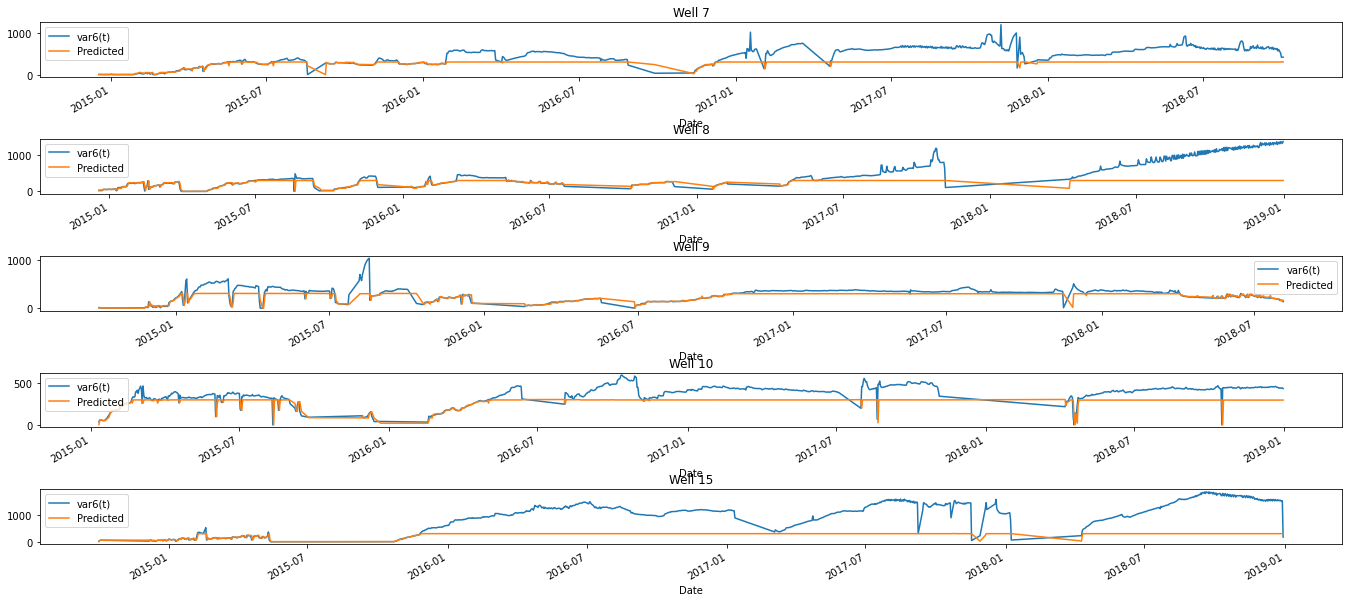

In [85]:
fig, axs = plt.subplots(len(well_no), 1, figsize=(20, 10), constrained_layout=False)
# fig.subplots_adjust(hspace = .5, wspace=.001)
fig.tight_layout(pad=5.0)

axs = axs.ravel()

for i in range(len(well_no)):
    Output_rf[f'{well_no[i]}'].plot(kind = 'line', ax = axs[i], title = f'{well_no[i]}')